In [2]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)
sns.set_style('white')

In [3]:
from mouselab import *
from distributions import *
from bayes_q import *
from gymrats.core import Agent
from exact import solve
from skopt import gp_minimize
from skopt.space import Real,Space

from joblib import Parallel, delayed

In [ ]:
cost_range = [0,0.3]
branch_range = [2,4]
height_range = [2,4]
reward_alpha = 1

In [11]:
def get_optimal_return(env):
    q, v, pi, info = solve(env)
    return v(env.init)

def sample_env():
    cost = np.random.uniform(*cost_range)
    branch = np.random.randint(*branch_range)
    height = np.random.randint(*height_range)
    R = Categorical([-1, 0, 1],np.random.dirichlet(np.ones(3)*reward_alpha))
    return MouselabEnv(branch, height, reward=R, cost=cost)

In [ ]:
def job(env):
    x = 0
    for i in range(100):
        x += create_training_df(env, make_prior_params(x_meta), 20).return_.mean()
    return x

envs = [sample_env() for i in range(500)]
results = Parallel(-1, backend='multiprocessing')(delayed(job)(env) for env in envs)

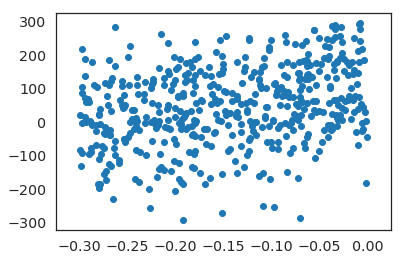

In [93]:
e = envs[0]
branch = [e.branch[0] for e in envs]
cost = [e.cost for e in envs]
plt.scatter(cost, results)

In [17]:
import random

def create_training_df(env, prior_params, n_episode):
    policy = BayesianQLearner(5, prior_params=prior_params)
    agent = Agent(env, policy)
    return pd.DataFrame(agent.run_many(n_episode, pbar=False))

def make_prior_params(x):
    if len(x) == 5:
        return np.r_[x[:5], np.ones(5) * 1e10, 1, 1]
    else:
        assert len(x) == 12
        return x

def training_return(x, seed=None, n_episode=20):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    df = create_training_df(sample_env(), make_prior_params(x), n_episode)
    return np.mean(df.return_.values)

# def global_training_objective_single(x):
#     prior_params = np.r_[x[:5], np.ones(5) * 1e10, x[5:]]
#     df = create_training_df(sample_env(), prior_params, n_episode)
#     return np.mean(df.return_.values)

def make_objective(single, N, parallel=True, **kwargs):
    def objective(x):
        if parallel:
            jobs = (delayed(single)(x, np.random.randint(100000000), **kwargs) for _ in range(N))
            returns = Parallel(-1, backend='multiprocessing')(jobs)
        else:
            returns = [single(x, **kwargs) for _ in range(N)]
        y = np.mean(returns)
        print(objective.counter, np.round(y, 3), np.round(x,2))
        objective.counter += 1
        return y
    objective.counter = 0
    return objective

array([0., 0., 0., 0., 1.])

In [100]:
    policy = BayesianQLearner(5, prior_params=None)

In [13]:
%time make_objective(training_return, N=100, n_episode=50)(np.ones(5))

0 0.277 [1. 1. 1. 1. 1.]
CPU times: user 261 ms, sys: 553 ms, total: 814 ms
Wall time: 3.64 s


0.2773977814806987

In [18]:
def train_agent(kind, n_iter=200, n_env=100, n_episode=25, **kwargs):
    dimensions = [Real(1, 20), Real(0,1), Real(0,1), Real(0,1), Real(0,2)]
    if kind == 'meta':
        dimensions.extend([Real(0.1,100)]*5 + [Real(0.1,20)] + [Real(0.1,10)])
    print(len(dimensions))
        
    objective = make_objective(training_return, N=n_env, n_episode=n_episode)
    return gp_minimize(lambda x: - objective(x),
                       dimensions=dimensions, n_calls=n_iter, **kwargs)

In [19]:
# global_res = train_agent('global', n_iter=200)
meta_res = train_agent('meta', n_iter=100, )

12
0 0.536 [ 6.41  0.59  0.48  0.35  0.61 49.95 25.02 31.29 99.23 66.28  5.77  4.47]
1 0.166 [13.2   0.26  0.88  0.12  1.34 41.37 35.58 89.07 18.73 45.71 10.72  2.14]
2 0.313 [16.    0.59  0.95  0.12  0.72 53.01 60.17 91.84 26.07 39.88  2.68  7.29]
3 0.476 [ 2.25  0.31  0.32  0.57  0.27 70.52 47.21 31.88 96.26 65.15  3.81  8.06]
4 0.351 [ 5.55  0.29  0.37  0.53  1.4  42.7  33.4  50.4  70.85 85.43  1.22  2.92]
5 0.181 [17.72  0.1   0.28  0.76  1.68 74.91 48.12 22.73  4.78 39.76  9.02  8.61]
6 0.295 [17.74  0.11  0.16  0.93  0.8  22.56 62.7  97.08 63.64 14.99  9.83  2.16]
7 0.314 [12.99  0.92  0.71  0.48  1.46 59.58 56.03 93.23 83.8   6.37  9.84  1.77]
8 0.312 [ 9.31  0.21  0.42  0.51  0.13  0.8  85.79 87.57 41.68 30.55 16.82  5.36]
9 0.409 [ 6.38  0.33  0.53  0.29  0.89 86.94 78.88 72.95 15.37 19.21  3.67  8.82]
10 0.52 [  1.     0.6    0.32   0.82   0.    57.2   87.15  88.26 100.    91.12   6.15   5.27]
11 0.434 [1.620e+00 9.000e-01 0.000e+00 1.100e-01 2.000e-02 8.138e+01 4.410e+01 2.6

89 0.3 [  1.     0.92   0.76   0.     0.84  41.09  70.9  100.     0.1    0.1    8.59   0.1 ]
90 0.386 [  1.     0.55   0.14   0.7    0.33   0.1   64.26   2.46 100.    68.36   5.07   7.81]
91 0.695 [  1.     0.55   1.     0.45   1.3   93.04  58.74 100.   100.    71.61   0.1    0.1 ]
92 0.563 [ 1.14  0.79  0.63  0.17  0.54 10.54 71.39 79.84 29.45 81.71  5.33  6.71]
93 0.463 [ 1.    0.43  0.82  0.68  1.37 30.68 66.17 86.53 41.4  81.79  8.25  1.25]
94 0.518 [ 1.    0.12  0.47  0.32  1.74 69.35 66.7  59.58 29.09 99.7  18.62  3.9 ]
95 0.757 [  1.     0.58   0.98   0.53   0.27  78.82 100.    17.65   5.28  35.37  19.59   1.59]
96 0.544 [ 3.46  0.2   0.35  0.64  0.5  79.14 67.38 22.    6.35 47.26 19.03  4.71]
97 0.426 [  1.14   0.     0.3    0.69   0.45   4.3  100.    41.28   5.25 100.    19.52   0.86]
98 0.462 [ 1.    1.    0.7   0.93  1.31 38.17 62.47 77.94 28.92 40.05 16.19  5.74]
99 0.542 [  1.     0.35   0.88   0.63   1.42  43.61 100.    90.45   4.96   9.47   2.41   2.88]
100 0.54 [ 3.24  

174 0.325 [ 1.    0.91  0.4   0.53  1.04 13.22 73.96 24.82 28.99 88.34 12.35  7.45]
175 0.166 [  1.     0.86   1.     0.4    0.    69.47  56.88 100.   100.    79.18   0.1    3.33]
176 -0.006 [  1.     0.51   1.     0.65   0.25  60.69  80.3  100.     0.1   50.14   2.15   6.89]
177 0.349 [3.990e+00 2.000e-02 7.900e-01 5.300e-01 0.000e+00 9.162e+01 1.000e+02 1.000e+02 1.000e+02 1.000e+02 1.558e+01 1.000e-01]
178 0.279 [  1.     0.     0.11   0.53   0.     7.37 100.   100.   100.   100.     0.26   7.52]
179 0.432 [  3.78   0.84   0.64   0.5    0.   100.    56.78 100.   100.    76.52   3.41   9.39]
180 0.283 [  1.     0.18   0.3    0.67   2.   100.     0.1  100.     0.1    0.1    7.83   6.15]
181 0.731 [  4.06   1.     0.41   0.56   1.34 100.    65.82 100.    61.58  71.05  18.64   8.54]
182 0.449 [3.660e+00 8.100e-01 8.000e-02 3.800e-01 1.830e+00 7.782e+01 6.868e+01 9.497e+01 4.161e+01 1.000e+02 1.831e+01 4.960e+00]
183 0.593 [  4.52   1.     0.     0.53   2.    96.63  66.82 100.    60.39  

In [21]:
from skopt import expected_minimum

def choose_x(res):
    objective = make_objective(training_return, N=1000)
    x_exp, f_exp_pred = expected_minimum(res)
    f_exp = objective(x_exp)
    x_emp, f_emp_pred = res.x, res.fun
    f_emp = objective(x_emp)
    print(f'Expected: {np.round(x_exp, 2)}  ->  {f_exp:.3f}  ({-f_exp_pred:.3f})')
    print(f'Empirical: {np.round(x_emp, 2)}  ->  {f_emp:.3f}  ({-f_emp_pred:.3f})')
    return x_exp if f_exp > f_emp else x_emp
    
x_meta = choose_x(meta_res)

0 0.531 [  3.82   1.     1.     0.54   2.    99.78  64.76 100.    56.91  95.44   8.91   0.1 ]
1 0.507 [  1.     0.58   0.98   0.53   0.27  78.82 100.    17.65   5.28  35.37  19.59   1.59]
Expected: [  3.82   1.     1.     0.54   2.    99.78  64.76 100.    56.91  95.44   8.91   0.1 ]  ->  0.531  (0.541)
Empirical: [  1.     0.58   0.98   0.53   0.27  78.82 100.    17.65   5.28  35.37  19.59   1.59]  ->  0.507  (0.757)


In [53]:
# from skopt import expected_minimum
# x_global, f_global = expected_minimum(global_res)
# print(np.round(x_global, 3))

# prm = make_prior_params(x_global)
# f_emp = make_objective(training_return, N=1000)(prm)
# print(f'Expected: {-f_global:.3f}')
# print(f'Empirical: {f_emp:.3f}')

# prm_100 = make_prior_params(x_global)
# prm_100[5:10] = 100
# f_100 = make_objective(training_return, N=1000)(prm_100)

# print(f'100: {f_100}')

# meta_res = train_agent('meta', n_iter=200, x0=[prm_100.tolist()], y0=[f_100])

/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0 0.55 [4.51e+00 1.00e+00 6.10e-01 5.00e-01 2.00e+00 1.00e+10 1.00e+10 1.00e+10 1.00e+10 1.00e+10 1.00e+00 1.00e+00]
Expected: -0.549
Empirical: 0.550


/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A wor

0 0.508 [  4.51   1.     0.61   0.5    2.   100.   100.   100.   100.   100.     1.     1.  ]
100: 0.5079569035419126


In [54]:
from tqdm import tqdm

def train(env, prior_params, n_episode, seed):
    np.random.seed(seed)
    random.seed(seed)
    df = create_training_df(env, prior_params, n_episode)
    return df.return_


def train_many(envs, x, n_episode=20):
    prior_params = make_prior_params(x)
    jobs = (delayed(train)(env, prior_params, n_episode, np.random.randint(10000000)) for env in envs)
    return Parallel(-1)((jobs))

x_baseline = list(np.r_[np.zeros(5), np.ones(5)*.01, 1,.1])
num_replications = 1000
envs = [sample_env() for _ in range(num_replications)]
# %time global_returns = train_many(envs, x_global)
%time meta_returns = train_many(envs, x_meta)
%time baseline_returns = train_many(envs, x_baseline)

CPU times: user 2.18 s, sys: 200 ms, total: 2.38 s
Wall time: 9.7 s


Text(0,0.5,'Return')

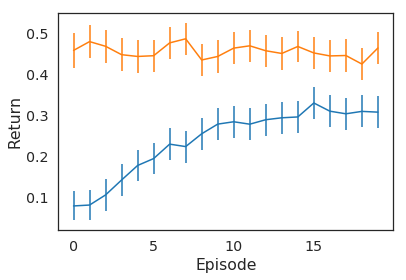

In [58]:
def plot_returns(X, **kwargs):
    plt.errorbar(x=np.arange(X.shape[1]),y=np.mean(X,axis=0),
             yerr=np.std(X,axis=0)/np.sqrt(X.shape[0]), **kwargs)
    
# plot_returns(np.stack(global_returns), label='Global')
plot_returns(np.stack(baseline_returns), label='Baseline')
plot_returns(np.stack(meta_returns), label='Meta')
plt.xlabel("Episode")
plt.ylabel("Return")

/usr/people/flc2/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


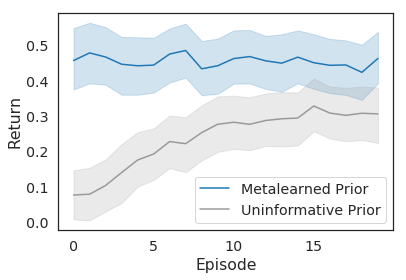

In [98]:

m = pd.melt(pd.DataFrame(np.stack(meta_returns)), var_name='Episode', value_name='Return')
sns.lineplot(m.Episode, m.Return)

n = pd.melt(pd.DataFrame(np.stack(baseline_returns)), var_name='Episode', value_name='Return')
sns.lineplot(n.Episode, n.Return, color=(0.6, 0.6, 0.6))


plt.legend(['Metalearned Prior', 'Uninformative Prior'], loc='lower right')
plt.savefig('figs/results.pdf',  pad_inches=0.1, bbox_inches='tight')

In [137]:
plt.errorbar(x=np.arange(global_returns.shape[1]),y=np.mean(global_returns,axis=0),
             yerr=np.std(global_returns,axis=0)/np.sqrt(global_returns.shape[0]),label='mean return of learned policy')
plt.errorbar(x=np.arange(meta_returns.shape[1]),y=np.mean(meta_returns,axis=0),
             yerr=np.std(meta_returns,axis=0)/np.sqrt(meta_returns.shape[0]),label='mean return of meta-learned policy')
#plt.errorbar(np.mean(returns_meta,axis=0),'.-',label='mean return of meta-learned policy')
#plt.plot(pd.DataFrame(np.mean(returns,axis=0)).rolling(10).mean(),'.-',label='mean return of learned policy')
#plt.axhline(np.mean(optimal_return),color='black',linestyle='dashed',label='return of optimal policy')
plt.legend(frameon=False)

plt.show()

#plt.show()
#df.n_steps.rolling(1).mean().plot()
#plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [145]:
np.savetxt('returns_notmeta.txt',returns)
np.savetxt('returns_meta.txt',returns_meta)

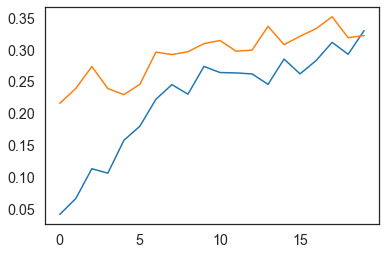

In [149]:
x = np.loadtxt('returns_notmeta.txt')
y = np.loadtxt('returns_meta.txt')
plt.plot(np.mean(x,axis=0))
plt.plot(np.mean(y,axis=0))